In [14]:
import os

# Cambiar el directorio de trabajo
ruta_nueva = 'C:/Users/ruben.morillas/Desktop/tfg/'  # Reemplaza 'TuUsuario' con tu nombre de usuario de Windows
os.chdir(ruta_nueva)

# Mostrar el directorio actual para confirmar el cambio
directorio_actual = os.getcwd()
print("Directorio actual:", directorio_actual)

Directorio actual: C:\Users\ruben.morillas\Desktop\tfg


In [15]:
import os
import pandas as pd
path_actual = os.getcwd()
subdirectorio = 'datas'
file_train = 'df_train.csv'
path_train = os.path.join(path_actual, subdirectorio, file_train)

In [16]:
import pandas as pd

df_train = pd.read_csv(path_train, index_col=None)


In [17]:
file_valid = 'df_valid.csv'
path_valid = os.path.join(path_actual, subdirectorio, file_valid)

df_valid = pd.read_csv(path_valid, index_col=None)

In [18]:
df_train = df_train.drop(['trueE'], axis=1)
df_valid = df_valid.drop(['trueE'], axis=1)


Este modulo será el encargado de entrenar los modelos de machine learning y ver los resultados que muetran. Además elegiremos los mejores hiperparametros para los modelos ya que estos modelos serán cargados de la biblioteca Scikit-learn.

Comprobaremos las diferencia de cada modelo para ver que modelo da mejores resultados.

Los modelos que vamos a usar son los siguientes:

*   **Regresión logistica:** Es un modelo lineal que es simple pero eficaz para problemas de clasificación binaria. Este modelo nos dará el punto de partida.

*   **Arboles de decisión:** Es un modelo versatil que puede usarse tanto para clasificación como para regresión. Los arboles de decisión son fáciles de interpretar y pueden capturar relaciones no lineales entre caracterisiticas.

*   **Random Forest:** Un ensamble de arboles de decisión. Es más robusto y preciso que un árbol unico de decisión debido a que reduce el riesgo de sobreajuste mediante el promedio de múltiples árboles

*   **SVM:** Es efectivo en espación de alta dimensión y casos donde el número de dimensiones es mayor que el número de muestras. Es útil tanto para la clasificación lineal como no lineal mediante el uso de diferentes kerneles.

*   **GBM:** Es una técnica de ensamble que construye modelos de forma secuencial, cada nuevo modelo corrige errores del modelo anterior.

*  **k-NN:** Es un modelo simple que clasifica puntos basándose en la mayoría de votos de sus k vecinos más cercanos. Es útil cuando las relaciones entre caracteristicas son complejas y no lineales.

*  **XGBoost:** es una implementación optimizada de árboles de decisión aplicados al algoritmo de Gradient Boosting. Es muy eficaz por su eficiencia en la ejecución.

*   **LightGBM:** es otro algoritmo de Gradient Boosting desarrollado por Microsoft que utiliza árboles basados en histogramas para el modelado.Utiliza la técnica de construcción de árboles basada en histogramas, que agrupa valores continuos en bins discretos



In [19]:
import numpy as np
import pandas as pd

def filtrado_datos(df, N):
    kaones = []
    labels = []

    df_sorted = df.sort_values(by=['eventID', 'hitTime'], ascending=[True, False])

    for eventID, grupo in df_sorted.groupby('eventID'):
        pdgCodes = grupo['PDGcode'].unique()

        for pdgCode in pdgCodes:
            grupo_filtrado = grupo[grupo['PDGcode'] == pdgCode]
            grupo_ordenado = grupo_filtrado.head(N)

            # Inicializar arrays para el padding
            hitX_padded = np.zeros(N)
            hitY_padded = np.zeros(N)
            hitZ_padded = np.zeros(N)
            hitInteg_padded = np.zeros(N)

            # Separar y aplicar padding a los valores de hitX, hitY, hitZ, hitInteg
            hitX_padded[:len(grupo_ordenado['hitX'])] = grupo_ordenado['hitX']
            hitY_padded[:len(grupo_ordenado['hitY'])] = grupo_ordenado['hitY']
            hitZ_padded[:len(grupo_ordenado['hitZ'])] = grupo_ordenado['hitZ']
            hitInteg_padded[:len(grupo_ordenado['hitInteg'])] = grupo_ordenado['hitInteg']

            # Concatenar los valores ya con el padding aplicado
            hit_values_reorganized = np.concatenate([hitX_padded, hitY_padded, hitZ_padded, hitInteg_padded])

            kaones.append(hit_values_reorganized)

            # Modificar las etiquetas de 211 a 0 y de 321 a 1
            if pdgCode == 211:
                labels.append(0)
            elif pdgCode == 321:
                labels.append(1)

    return np.array(kaones), np.array(labels)


In [20]:
!pip install xgboost lightgbm

Hacemos un import de todos los modelos que vamos a usar

In [21]:
from sklearn.linear_model import LogisticRegression # Regresión logistica
from sklearn.tree import DecisionTreeClassifier # Arbol de decision
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.svm import SVC # SVM
from sklearn.ensemble import GradientBoostingClassifier # Gradient Boosting Machine
from sklearn.neighbors import KNeighborsClassifier # k-NN
import xgboost as xgb
from lightgbm import LGBMClassifier # LightGBM

Hacemos un import de todas las metricas que vamos a usar

In [22]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score


Como hemos indicado en el notebook `estadisticas.ipynb`, para tratar de encontrar el mejor valor de N realizaremos varios entrenamientos con distintos valores de N para ver el comporamiento de los modelos. El valor de N ira en el intervalo [400,800] en saltos de 40. A continuación crearemos el array.

In [23]:
valores_N = np.arange(400,801,40)
valores_N

array([400, 440, 480, 520, 560, 600, 640, 680, 720, 760, 800])

Creamos una funcion que pasandole el modelo, los datos de train, las etiquetas de train, devuelve las metricas para validar el modelo

In [24]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score

def train_metrics(modelo, x_train, y_train, x_valid, y_valid):
    modelo.fit(x_train, y_train)
    y_predic = modelo.predict(x_valid)

    # Obtener probabilidades para la clase positiva
    y_proba = modelo.predict_proba(x_valid)[:, 1]  # Asumiendo que es una clasificación binaria

    # Calculo de métricas de error
    accuracy = accuracy_score(y_valid, y_predic)
    f1 = f1_score(y_valid, y_predic)
    recall = recall_score(y_valid, y_predic)
    roc_auc = roc_auc_score(y_valid, y_proba)  # Usando las probabilidades y las verdaderas etiquetas

    return accuracy, f1, recall, roc_auc


In [25]:
from sklearn.base import clone
import time

def metricas_entrenamiento_valores_N(modelo_base, df_train, df_valid, valores_N):
    accuracy_modelo = np.array([])
    f1_modelo = np.array([])
    recall_modelo = np.array([])
    roc_auc_modelo = np.array([])

    for N in valores_N:
        # Clonar el modelo base para asegurar que se empiece con un modelo no entrenado
        modelo = clone(modelo_base)

        x_train, y_train = filtrado_datos(df_train, N)
        x_valid, y_valid = filtrado_datos(df_valid, N)

        inicio_entrenamiento = time.time()
        print('Inicio de entrenamiento con', N, 'hits por evento')
        accuracy, f1, recall, roc_auc = train_metrics(modelo, x_train, y_train, x_valid, y_valid)
        fin_entrenamiento = time.time()
        print('La duracion del entrenamiento con', N, 'hits por evento es de:', fin_entrenamiento-inicio_entrenamiento)
        
        accuracy_modelo = np.append(accuracy_modelo, accuracy)
        f1_modelo = np.append(f1_modelo, f1)
        recall_modelo = np.append(recall_modelo, recall)
        roc_auc_modelo = np.append(roc_auc_modelo, roc_auc)

    return accuracy_modelo, f1_modelo, recall_modelo, roc_auc_modelo


> **Regresión logisitica (LogisticRegression)** : [documentacion](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)


*   **penalty=l2**: debido a que todas las caracteristicas son importantes.
*   **solver='lbfgs'**: Puede manejar problemas de optimización de gran escala de manera más eficiente en términos de memoria. Soporta la regularización l2. Los datos de los que disponemos son datos suaves y relativamente bien comportados por ese motivo puede converger más rapidamente.
*   **random_state=42**: Para la reproducibilidad de los resultados
*   **max_iter=500**: Para que el número máximo de iteraciones que realice no sea mayor de 500
*   **multi_class='ovr'**: ya que es un problema de clasificación binaria



In [26]:
# Cargamos el modelo
## Regresion Logistica
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

RL = LogisticRegression(penalty='l2', solver='lbfgs', random_state=42, max_iter=500, multi_class = 'ovr')
accuracy_RL, f1_RL, recall_RL, roc_RL = metricas_entrenamiento_valores_N(RL, df_train, df_valid, valores_N)


Inicio de entrenamiento con 400 hits por evento
La duracion del entrenamiento con 400 hits por evento es de: 18.919333696365356
Inicio de entrenamiento con 440 hits por evento
La duracion del entrenamiento con 440 hits por evento es de: 20.092868328094482
Inicio de entrenamiento con 480 hits por evento
La duracion del entrenamiento con 480 hits por evento es de: 21.815819025039673
Inicio de entrenamiento con 520 hits por evento
La duracion del entrenamiento con 520 hits por evento es de: 25.65069341659546
Inicio de entrenamiento con 560 hits por evento
La duracion del entrenamiento con 560 hits por evento es de: 26.859617710113525
Inicio de entrenamiento con 600 hits por evento
La duracion del entrenamiento con 600 hits por evento es de: 29.0159330368042
Inicio de entrenamiento con 640 hits por evento
La duracion del entrenamiento con 640 hits por evento es de: 31.503268480300903
Inicio de entrenamiento con 680 hits por evento
La duracion del entrenamiento con 680 hits por evento es de

> **Random Forest Classifier** [documentacion](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn-ensemble-randomforestclassifier)

*   **n_estimators=100**: El numero de arboles en la busqueda
*   **criterion='entropy'**: Es más sensible a las diferencias entre las distribuciones de ambas clases. Eso significa que es capaz de identificar divisiones que resulten en una mayor ganancia de informacion, especialmente en casos donde estas diferencias son pequeñas, como pasa en nuestro dataset. El incoveniente es que tienen un mayor coste computacional ya que requiere el uso de logaritmos.
*   **max_depth=None**: Para que los nodos se expandan hasta que todas las hojas sean puras.
*   **max_features=None**: Representa el numero de features para considerear cuando buscamos el mejor separador de clases. Al elegir None hacemos que número maximos de features a elegir sea el numero de features propiamente dicho.
*   **random_state=42**: Para poder reproducir los resultados



In [27]:
RF = RandomForestClassifier(n_estimators=50, criterion='gini', max_depth=None, max_features='sqrt', random_state=42)
accuracy_RF, f1_RF, recall_RF, roc_RF = metricas_entrenamiento_valores_N(RF, df_train, df_valid, valores_N)

Inicio de entrenamiento con 400 hits por evento
La duracion del entrenamiento con 400 hits por evento es de: 217.81812024116516
Inicio de entrenamiento con 440 hits por evento
La duracion del entrenamiento con 440 hits por evento es de: 216.3689739704132
Inicio de entrenamiento con 480 hits por evento
La duracion del entrenamiento con 480 hits por evento es de: 220.5928716659546
Inicio de entrenamiento con 520 hits por evento
La duracion del entrenamiento con 520 hits por evento es de: 224.35297298431396
Inicio de entrenamiento con 560 hits por evento
La duracion del entrenamiento con 560 hits por evento es de: 226.02573323249817
Inicio de entrenamiento con 600 hits por evento
La duracion del entrenamiento con 600 hits por evento es de: 219.05710983276367
Inicio de entrenamiento con 640 hits por evento
La duracion del entrenamiento con 640 hits por evento es de: 220.58709740638733
Inicio de entrenamiento con 680 hits por evento
La duracion del entrenamiento con 680 hits por evento es d

In [28]:
GBC = GradientBoostingClassifier(loss='log_loss', n_estimators=100, criterion='friedman_mse', max_features='sqrt', random_state=42, learning_rate=0.1)
accuracy_GBC, f1_GBC, recall_GBC, roc_GBC = metricas_entrenamiento_valores_N(GBC, df_train, df_valid, valores_N)

Inicio de entrenamiento con 400 hits por evento
La duracion del entrenamiento con 400 hits por evento es de: 93.06483340263367
Inicio de entrenamiento con 440 hits por evento
La duracion del entrenamiento con 440 hits por evento es de: 92.40373945236206
Inicio de entrenamiento con 480 hits por evento
La duracion del entrenamiento con 480 hits por evento es de: 92.6737277507782
Inicio de entrenamiento con 520 hits por evento
La duracion del entrenamiento con 520 hits por evento es de: 93.02827000617981
Inicio de entrenamiento con 560 hits por evento
La duracion del entrenamiento con 560 hits por evento es de: 93.71075582504272
Inicio de entrenamiento con 600 hits por evento
La duracion del entrenamiento con 600 hits por evento es de: 92.70662999153137
Inicio de entrenamiento con 640 hits por evento
La duracion del entrenamiento con 640 hits por evento es de: 92.94805812835693
Inicio de entrenamiento con 680 hits por evento
La duracion del entrenamiento con 680 hits por evento es de: 94.

In [29]:
SVM_model = SVC(kernel='rbf', gamma='scale', random_state=42, probability=True)
accuracy_SVM, f1_SVM, recall_SVM, roc_SVM = metricas_entrenamiento_valores_N(SVM_model, df_train, df_valid, valores_N)

Inicio de entrenamiento con 400 hits por evento
La duracion del entrenamiento con 400 hits por evento es de: 3170.0443663597107
Inicio de entrenamiento con 440 hits por evento
La duracion del entrenamiento con 440 hits por evento es de: 3411.8346190452576
Inicio de entrenamiento con 480 hits por evento
La duracion del entrenamiento con 480 hits por evento es de: 3696.346805334091
Inicio de entrenamiento con 520 hits por evento
La duracion del entrenamiento con 520 hits por evento es de: 3997.5907521247864
Inicio de entrenamiento con 560 hits por evento
La duracion del entrenamiento con 560 hits por evento es de: 4245.462070226669
Inicio de entrenamiento con 600 hits por evento
La duracion del entrenamiento con 600 hits por evento es de: 4556.962115526199
Inicio de entrenamiento con 640 hits por evento
La duracion del entrenamiento con 640 hits por evento es de: 4891.70036649704
Inicio de entrenamiento con 680 hits por evento
La duracion del entrenamiento con 680 hits por evento es de: 

In [31]:
DTC = DecisionTreeClassifier(criterion='gini', splitter='best', random_state=42)
accuracy_DTC, f1_DTC, recall_DTC, roc_DTC = metricas_entrenamiento_valores_N(DTC, df_train, df_valid, valores_N)

Inicio de entrenamiento con 400 hits por evento
La duracion del entrenamiento con 400 hits por evento es de: 307.86365699768066
Inicio de entrenamiento con 440 hits por evento
La duracion del entrenamiento con 440 hits por evento es de: 307.55777072906494
Inicio de entrenamiento con 480 hits por evento
La duracion del entrenamiento con 480 hits por evento es de: 393.1674964427948
Inicio de entrenamiento con 520 hits por evento
La duracion del entrenamiento con 520 hits por evento es de: 368.49100065231323
Inicio de entrenamiento con 560 hits por evento
La duracion del entrenamiento con 560 hits por evento es de: 321.81047677993774
Inicio de entrenamiento con 600 hits por evento
La duracion del entrenamiento con 600 hits por evento es de: 323.596337556839
Inicio de entrenamiento con 640 hits por evento
La duracion del entrenamiento con 640 hits por evento es de: 343.0830979347229
Inicio de entrenamiento con 680 hits por evento
La duracion del entrenamiento con 680 hits por evento es de:

In [33]:
KNN = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='minkowski')
accuracy_KNN, f1_KNN, recall_KNN, roc_KNN = metricas_entrenamiento_valores_N(KNN, df_train, df_valid, valores_N)

Inicio de entrenamiento con 400 hits por evento
La duracion del entrenamiento con 400 hits por evento es de: 16.618404626846313
Inicio de entrenamiento con 440 hits por evento
La duracion del entrenamiento con 440 hits por evento es de: 16.050290822982788
Inicio de entrenamiento con 480 hits por evento
La duracion del entrenamiento con 480 hits por evento es de: 17.26814603805542
Inicio de entrenamiento con 520 hits por evento
La duracion del entrenamiento con 520 hits por evento es de: 18.693177223205566
Inicio de entrenamiento con 560 hits por evento
La duracion del entrenamiento con 560 hits por evento es de: 20.31341028213501
Inicio de entrenamiento con 600 hits por evento
La duracion del entrenamiento con 600 hits por evento es de: 21.369690895080566
Inicio de entrenamiento con 640 hits por evento
La duracion del entrenamiento con 640 hits por evento es de: 23.12131643295288
Inicio de entrenamiento con 680 hits por evento
La duracion del entrenamiento con 680 hits por evento es de

In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score
import xgboost as xgb

# Supongamos que tienes tus datos en los DataFrames df_train y df_valid, y tus etiquetas en y_train y y_valid
# Supongamos también que tienes definidos tus valores_N

accuracy_XGB = np.array([])
f1_XGB = np.array([])
recall_XGB = np.array([])
roc_XGB = np.array([])

for N in valores_N:
    X_train, y_train = filtrado_datos(df_train, N)
    X_valid, y_valid = filtrado_datos(df_valid, N)
    
    # Convertir los datos a la estructura DMatrix de XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    
    params = {
        'booster': 'gbtree',
        'max_depth': 6,
        'gamma': 0,
        'learning_rate': 0.3,
        'subsample': 1,
        'colsample_bytree': 1,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'seed': 42
    }
    
    num_round = 100
    bst = xgb.train(params, dtrain, num_round, evals=[(dvalid, 'validation')])
    y_pred_proba = bst.predict(dvalid)
    y_pred = np.round(y_pred_proba)

    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_pred)

    accuracy_XGB = np.append(accuracy_XGB, accuracy)
    f1_XGB = np.append(f1_XGB, f1)
    recall_XGB = np.append(recall_XGB, recall)
    roc_XGB = np.append(roc_XGB, roc_auc)


[0]	validation-logloss:0.54030
[1]	validation-logloss:0.45152
[2]	validation-logloss:0.38947
[3]	validation-logloss:0.34907
[4]	validation-logloss:0.31999
[5]	validation-logloss:0.29825
[6]	validation-logloss:0.27935
[7]	validation-logloss:0.26438
[8]	validation-logloss:0.25272
[9]	validation-logloss:0.24313
[10]	validation-logloss:0.23391
[11]	validation-logloss:0.22605
[12]	validation-logloss:0.22188
[13]	validation-logloss:0.21633
[14]	validation-logloss:0.21178
[15]	validation-logloss:0.20956
[16]	validation-logloss:0.20624
[17]	validation-logloss:0.20204
[18]	validation-logloss:0.19977
[19]	validation-logloss:0.19847
[20]	validation-logloss:0.19664
[21]	validation-logloss:0.19494
[22]	validation-logloss:0.19281
[23]	validation-logloss:0.19140
[24]	validation-logloss:0.18951
[25]	validation-logloss:0.18887
[26]	validation-logloss:0.18743
[27]	validation-logloss:0.18621
[28]	validation-logloss:0.18570
[29]	validation-logloss:0.18499
[30]	validation-logloss:0.18397
[31]	validation-lo

In [36]:
lgbm = LGBMClassifier(boosting_type='gbdt', max_depth=6, learning_rate=0.3, subsample=1, colsample_bytree=1, random_state=42)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
accuracy_LGBM, f1_LGBM, recall_LGBM, roc_LGBM = metricas_entrenamiento_valores_N(lgbm, df_train, df_valid, valores_N)

Inicio de entrenamiento con 400 hits por evento
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13963, number of negative: 13652
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.678850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 408000
[LightGBM] [Info] Number of data points in the train set: 27615, number of used features: 1600
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505631 -> initscore=0.022525
[LightGBM] [Info] Start training from score 0.022525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [37]:
import matplotlib.pyplot as plt

def graficar_metricas(valores_N, accuracy, f1, recall, roc_auc,titulo):
    plt.figure(figsize=(10, 6))

    # Graficar las métricas en la misma gráfica
    plt.plot(valores_N, accuracy, label='Accuracy', marker='_', color='blue')
    plt.plot(valores_N, f1, label='F1 Score', marker='_')
    plt.plot(valores_N, recall, label='Recall', marker='_')
    plt.plot(valores_N, roc_auc, label='Roc Auc', marker='_')

    plt.title('Métricas de Evaluación en función de N '+titulo)
    plt.xlabel('N')
    plt.ylabel('Métrica')
    plt.legend()
    plt.grid(True)

    plt.show()


In [38]:
import matplotlib.pyplot as plt

def comparar_metricas_modelos(valores_N, metrica1, metrica2, metrica3, metrica4, metrica5, metrica6, metrica7, metrica8, titulo):
    plt.figure(figsize=(10, 6))

    # Graficar las métricas en la misma gráfica
    plt.plot(valores_N, metrica1, label='Regresion Logistica', marker='_')
    plt.plot(valores_N, metrica2, label='Random Forest', marker='_')
    plt.plot(valores_N, metrica3, label='DTC', marker='_')
    plt.plot(valores_N, metrica4, label='SVM', marker='_')
    plt.plot(valores_N, metrica5, label='GBC', marker='_')
    plt.plot(valores_N, metrica6, label='KNN', marker='_')
    plt.plot(valores_N, metrica7, label='XGB', marker='_')
    plt.plot(valores_N, metrica8, label='LGBM', marker='_')



    plt.title('Comparacion de '+titulo+ ' de los diferentes modelos')
    plt.xlabel('N')
    plt.ylabel('Métrica')
    plt.legend()
    plt.grid(True)

    plt.show()


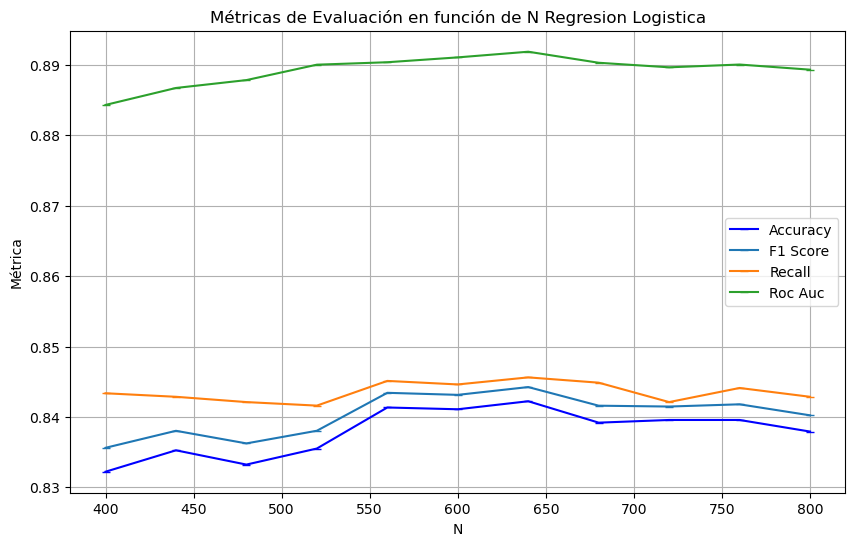

In [39]:
graficar_metricas(valores_N, accuracy_RL, f1_RL, recall_RL, roc_RL, titulo='Regresion Logistica')

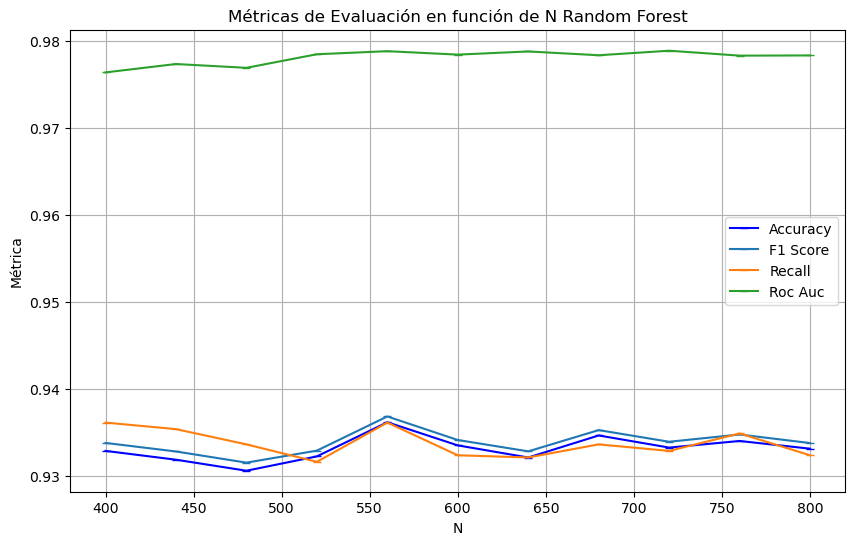

In [40]:
graficar_metricas(valores_N, accuracy_RF, f1_RF, recall_RF, roc_RF, titulo='Random Forest')

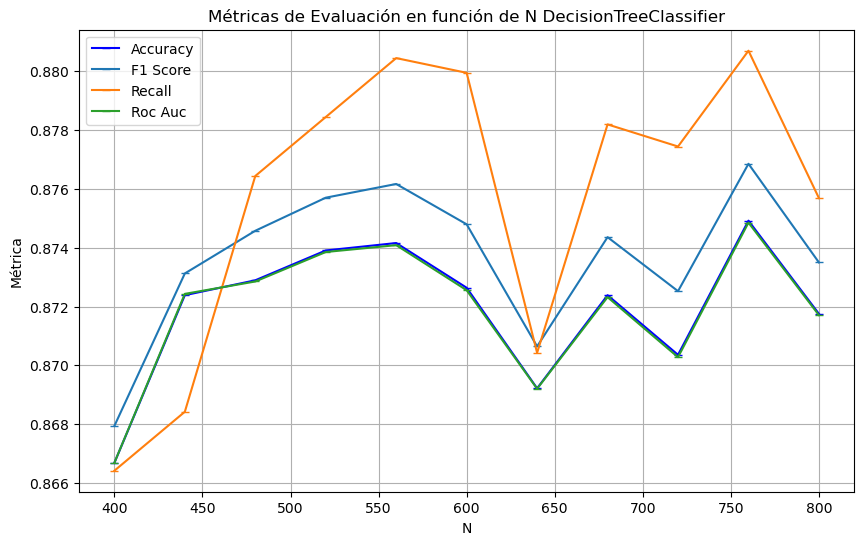

In [41]:
graficar_metricas(valores_N, accuracy_DTC, f1_DTC, recall_DTC, roc_DTC, titulo='DecisionTreeClassifier')

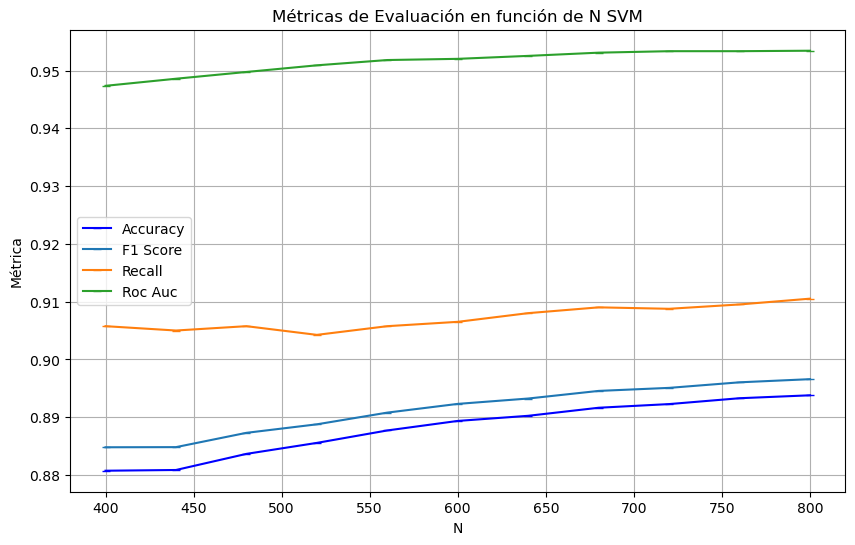

In [42]:
graficar_metricas(valores_N, accuracy_SVM, f1_SVM, recall_SVM, roc_SVM, titulo='SVM')

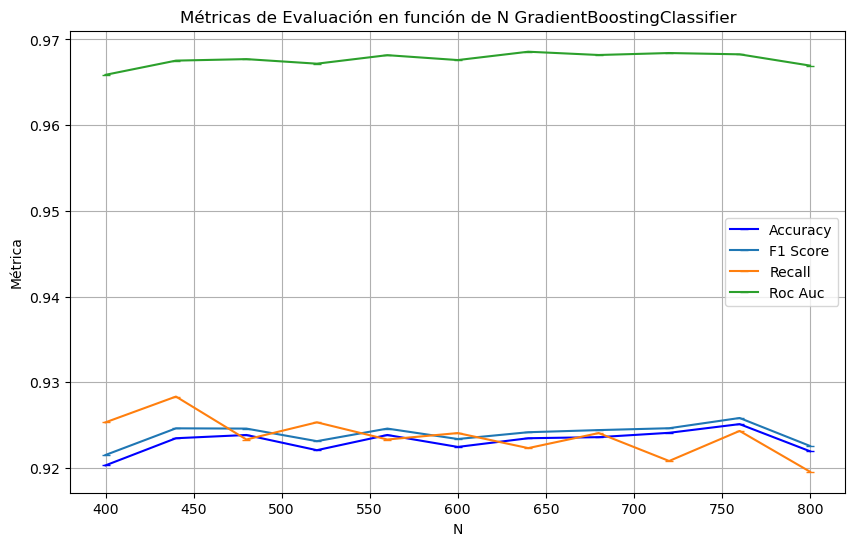

In [43]:
graficar_metricas(valores_N, accuracy_GBC, f1_GBC, recall_GBC, roc_GBC, titulo='GradientBoostingClassifier')

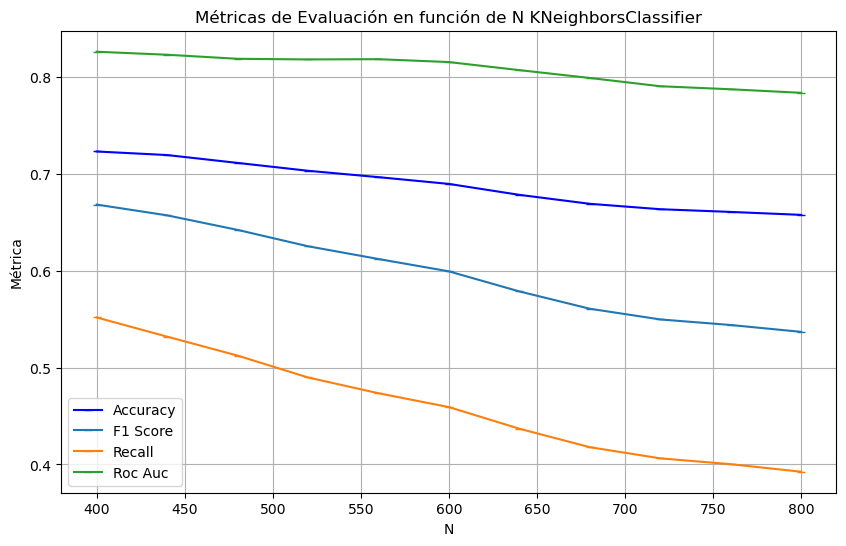

In [44]:
graficar_metricas(valores_N, accuracy_KNN, f1_KNN, recall_KNN, roc_KNN, titulo='KNeighborsClassifier')

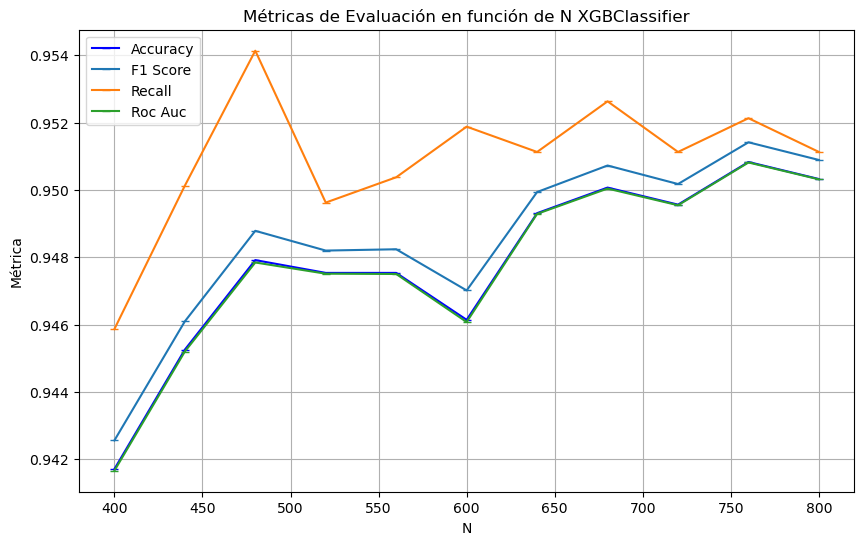

In [45]:
graficar_metricas(valores_N, accuracy_XGB, f1_XGB, recall_XGB, roc_XGB, titulo='XGBClassifier')

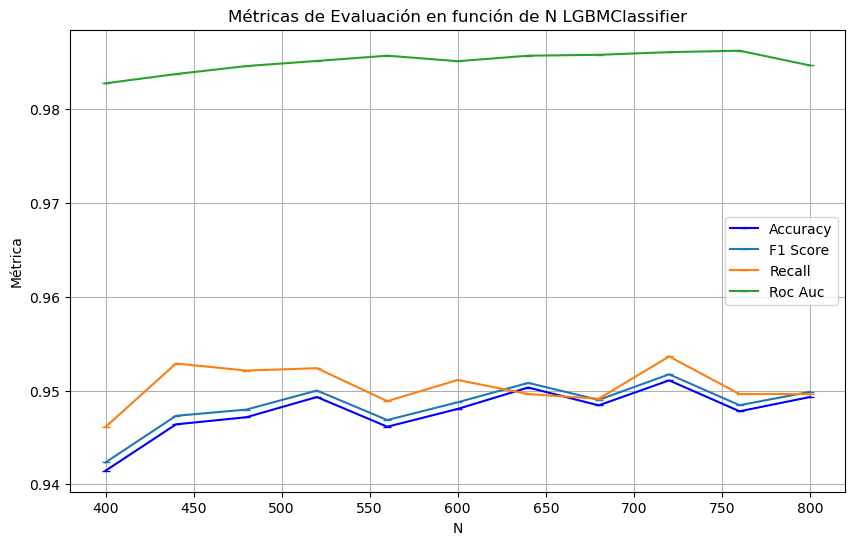

In [46]:
graficar_metricas(valores_N, accuracy_LGBM, f1_LGBM, recall_LGBM, roc_LGBM, titulo='LGBMClassifier')

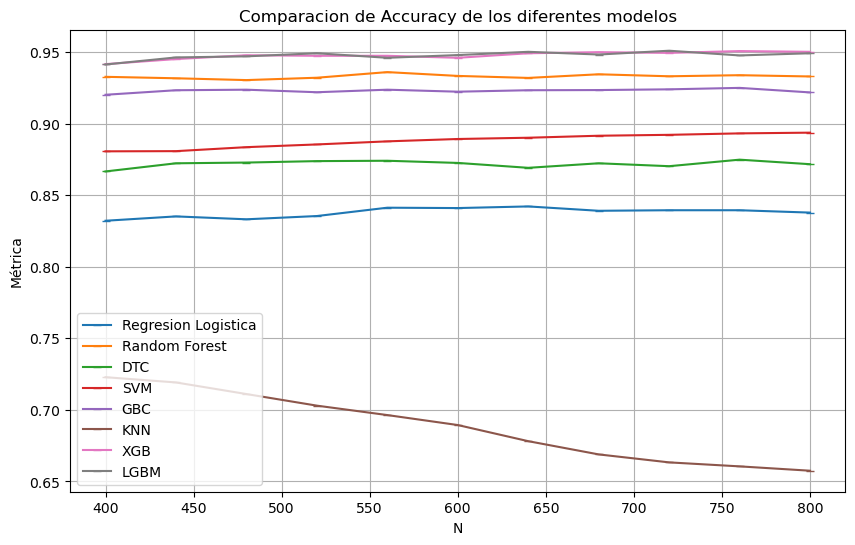

In [47]:
comparar_metricas_modelos(valores_N, accuracy_RL, accuracy_RF, accuracy_DTC, accuracy_SVM, accuracy_GBC, accuracy_KNN, accuracy_XGB, accuracy_LGBM, 'Accuracy')

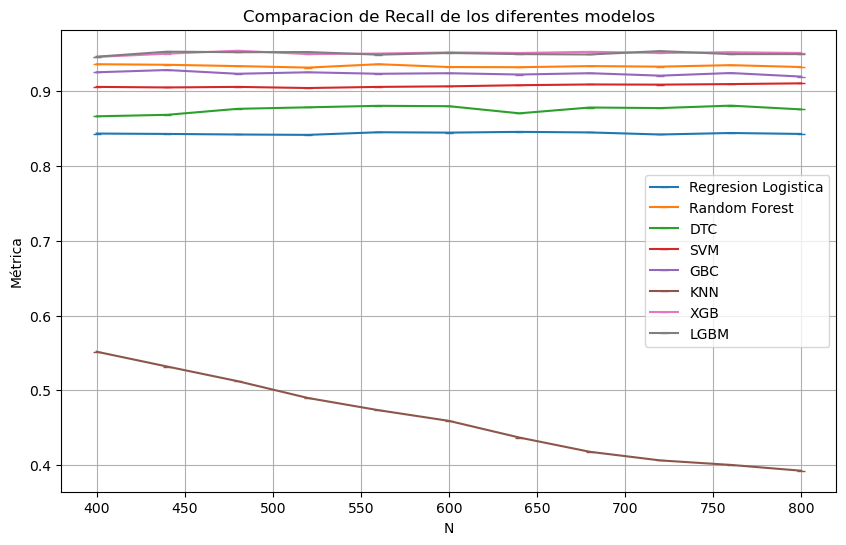

In [48]:
comparar_metricas_modelos(valores_N, recall_RL, recall_RF, recall_DTC, recall_SVM, recall_GBC, recall_KNN, recall_XGB, recall_LGBM, 'Recall')

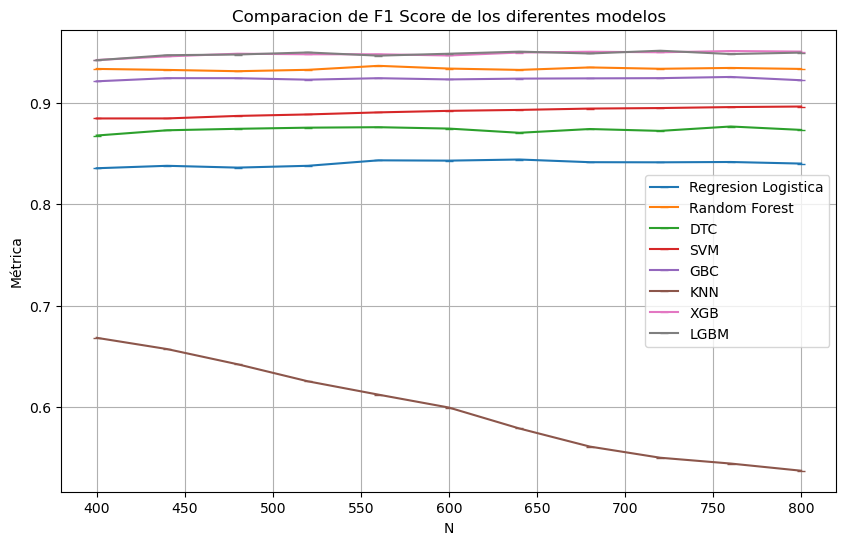

In [49]:
comparar_metricas_modelos(valores_N, f1_RL, f1_RF, f1_DTC, f1_SVM, f1_GBC, f1_KNN, f1_XGB, f1_LGBM, 'F1 Score')

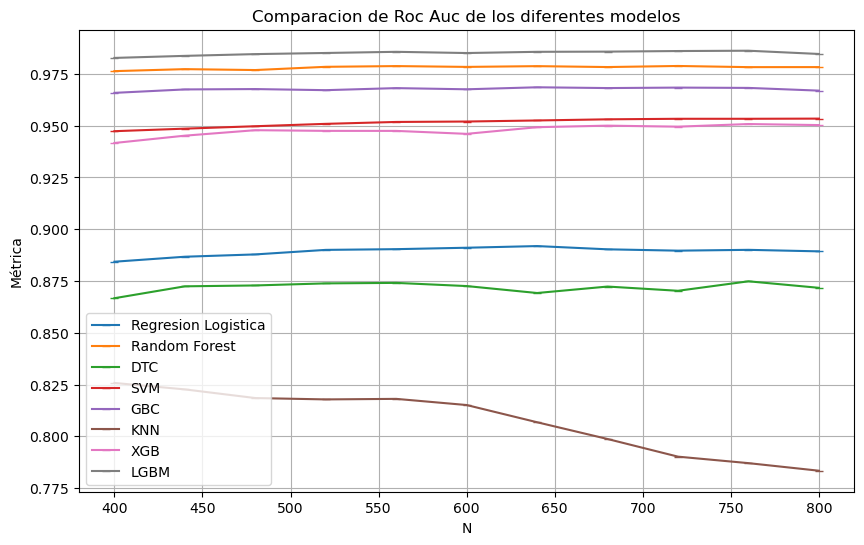

In [50]:
comparar_metricas_modelos(valores_N, roc_RL, roc_RF, roc_DTC, roc_SVM, roc_GBC, roc_KNN, roc_XGB, roc_LGBM, 'Roc Auc')

## Eleccion de las mejores N

Los mejores modelos según las métricas anteriores son los siguientes:
*   **LGBM**
*   **Random Forest**
*   **GBC**
*   **SVM**
Por tanto elegiremos los mejores valores de N para cada modelo según sus métricas:    

In [ ]:
def mejor_N(accuracy, recall, f1, roc, valores_N):
    mejor_accuracy = max(accuracy)
    mejor_recall = max(recall)
    mejor_f1 = max(f1)
    mejor_roc = max(roc)

    indice_mejor_accuracy = accuracy.index(mejor_accuracy)
    indice_mejor_recall = recall.index(mejor_recall)
    indice_mejor_f1 = f1.index(mejor_f1)
    indice_mejor_roc = roc.index(mejor_roc)

    # Calculamos la intersección de los índices de las métricas para encontrar el valor de N que maximiza todas las métricas
    indices_interseccion = set([indice_mejor_accuracy, indice_mejor_recall, indice_mejor_f1, indice_mejor_roc])

    # Encontramos el valor de N que maximiza todas las métricas
    mejor_N = valores_N[list(indices_interseccion)[0]]

    return mejor_N


In [ ]:
# Calculamos la mejor N de cada modelo de los 4 elegidos
N_LGBM = mejor_N(accuracy_LGBM, recall_LGBM, f1_LGBM, roc_LGBM, valores_N)
N_RF = mejor_N(accuracy_RF, recall_RF, f1_RF, roc_RF, valores_N)
N_GBC = mejor_N(accuracy_GBC, recall_GBC, f1_GBC, roc_GBC, valores_N)
N_SVM = mejor_N(accuracy_SVM, recall_SVM, f1_SVM, roc_SVM, valores_N)

print('El mejor valor N para LGBM es:', N_LGBM)
print('El mejor valos N para RF es:', N_RF)
print('El mejor valor N para GBC es:', N_GBC)
print('El mejor valor N para SVM es:', N_SVM)